# 📘 Learning Rate Strategies in Reinforcement Learning

This notebook explores and compares different learning rate adaptation strategies in the context of optimization under noise — with a particular focus on their potential application to reinforcement learning (RL).  
We implement and analyze three optimization algorithms:

- **Gradient Descent** with optional adaptive learning rate,
- **Adam** extended with a path-based adaptation mechanism (CLARA),
- **Evolution Strategies** with cumulative step-size control.

The core idea is to investigate how learning rates can be adapted dynamically using information from the **history of update directions**, especially under **noisy and ill-conditioned settings** that are typical in RL.  
To this end, we introduce a CLARA-like mechanism that accumulates update directions over time and adjusts the learning rate based on the **norm and consistency** of these updates. We also include noisy versions of benchmark functions (Sphere, Ellipsoid) to simulate stochastic environments.

This notebook serves as an experimental framework for analyzing the stability, convergence, and robustness of different learning rate strategies — and lays the groundwork for applying these insights to deep RL.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import für 3D-Plots
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go

---
## 🧮 Objective Functions and Gradients

Defines the Sphere and Ellipsoid test functions along with their gradients, both clean and noisy. These serve as toy problems to study optimization under noise and ill-conditioning.


In [11]:
# Define the Sphere function (a simple quadratic function)
def sphere(x):
    return np.sum(x**2)

# Gradient of the Sphere function (analytically known)
def grad_sphere(x):
    return 2 * x

# Define a noisy version of the Sphere function (adds multiplicative noise)
def noisy_sphere(x):
    noise = np.random.normal(loc=0, scale=0.01)  # Small Gaussian noise
    return np.sum(x**2) * np.exp(noise)

# Gradient of the noisy Sphere function (adds noise to the gradient)
def noisy_grad_sphere(x):
    noise = np.random.randn(*x.shape) * 0.5  # Gaussian noise scaled by 0.5
    return 2 * (1 + noise) * x

In [12]:
cond = 1e6

# Define the Ellipsoid function (a generalization of the Sphere function with conditioning)
def ellipsoid(x, cond=cond):
    return sum(cond**(np.arange(len(x)) / (len(x) - 1 + 1e-9)) * np.asarray(x)**2)

# Gradient of the Ellipsoid function (analytically known)
def grad_ellipsoid(x, cond=cond):
    noise = np.random.randn(*x.shape)  # Additive Gaussian noise
    return 2 * cond**(np.arange(len(x)) / (len(x) - 1 + 1e-9)) * np.asarray(x) + noise * np.linalg.norm(x)

# Define a noisy version of the Ellipsoid function (adds multiplicative noise)
def noisy_ellipsoid(x, cond=cond):
    noise = np.random.normal(loc=0, scale=0.01)  # Small Gaussian noise
    return sum(cond**(np.arange(len(x)) / (len(x) - 1 + 1e-9)) * np.asarray(x)**2) * np.exp(noise)

# Gradient of the noisy Ellipsoid function (adds noise to the gradient)
def noisy_grad_ellipsoid(x, cond=cond):
    noise = np.random.randn(*x.shape) * 0.5  # Gaussian noise scaled by 0.5
    return 2 * (1 + noise) * cond**(np.arange(len(x)) / (len(x) - 1 + 1e-9)) * np.asarray(x)

----
## ⚙️ Optimizers Implementation

### Evolution Strategy (ES)

Implements a simple (μ, λ)-evolution strategy with adaptive step size control using a CLARA-style cumulative path update.

In [13]:
def evolution_strategy(f, x0, sigma, iterations=100, mu=5, lambda_=10):
    """Implements an Evolution Strategy (ES) optimization algorithm with Cumulative LeArning Rate Adaptation (CLARA)."""
    
    dim = len(x0)
    x = x0

    # Initialize path variable, smoothing and damping factors for Cumulative LeArning Rate Adaptation (CLARA)
    path = np.zeros(dim)
    c = 0.2
    d = 1

    # Initialize return variables
    candidate_solutions = []
    step_size = []
    path_norm = []
    step_norm = []

    weights = np.linspace(1, 2, mu)  # Assign higher weight to best individuals
    weights /= weights.sum()  # Normalize weights to sum to 1

    for i in range(iterations):
        # Generate offspring
        pop = np.random.randn(lambda_, dim)

        # Select mu best individuals
        selected = pop[np.argsort([f(x + sigma * ind) for ind in pop])[:mu]]

        # Update current solution
        step = np.sum(selected.T * weights, axis=1)
        x = x + sigma * step
        candidate_solutions.append(x)

        # Update path
        path = (1 - c) * path + np.sqrt(c * (2 - c)) * step
        path_norm.append(np.linalg.norm(path))
        step_norm.append(np.linalg.norm(step))

        # Update step-size
        sigma = sigma * np.exp(c / (2 * d) * ((np.linalg.norm(path)**2 / dim) - 1))
        step_size.append(sigma)


        print(f'Iteration {i}: current fitness = {f(x)}')

    return candidate_solutions, step_size, path_norm, step_norm

### Gradient Descent with CLARA

Standard gradient descent with optional adaptive learning rate based on a cumulative path norm (CLARA-like adaptation).

In [14]:
def gradient_descent(gradient, x0, lr=0.1, iterations=100, adapt_lr=True):
    """
    Performs gradient descent to minimize a function.

    :param gradient: Function that computes the gradient ∇f(x).
    :param x0: Initial guess (NumPy array).
    :param lr: Learning rate (step size).
    :param iterations: Number of iterations.
    :return: Final optimized value of x.
    """
    x = x0  # Initialize x
    dim = len(x0)  # Get dimension of search space

    # Initialize path variable, smoothing and damping factors for Cumulative LeArning Rate Adaptation (CLARA)
    path = np.zeros(dim)
    c = 0.2
    d = 1

    # Initialize return variables
    candidate_solutions = []
    learning_rate = []
    path_norm = []
    gradient_norm = []

    for _ in range(iterations):
        grad = gradient(x)  # Compute gradient
        step = grad.copy()
        if adapt_lr:
            step /= np.linalg.norm(step)  # TODO: Handle division by zero
        x = x - lr * step # Update step

        # Update path
        path = (1 - c) * path + np.sqrt(c * (2 - c)) * step

        # Update learning rate
        if adapt_lr:
            lr = lr * np.exp(c / (2 * d) * (np.linalg.norm(path)**2 / dim - 1))

        candidate_solutions.append(x)
        learning_rate.append(lr)
        path_norm.append(np.linalg.norm(path))
        gradient_norm.append(np.linalg.norm(grad))

    print('Optimized x: ', x)

    return candidate_solutions, learning_rate, path_norm, gradient_norm

### Adam Optimizer with Path-based Adaptation

Extends Adam with path accumulation and CLARA-style adaptive learning rate. The update direction is normalized and used to control the learning rate based on its alignment over time.

In [15]:
def adam(gradient, x0, lr=0.1, iterations=100, adapt_lr=True):
    """
    Performs gradient descent to minimize a function.

    :param gradient: Function that computes the gradient ∇f(x).
    :param x0: Initial guess (NumPy array).
    :param lr: Learning rate (step size).
    :param iterations: Number of iterations.
    :return: Final optimized value of x.
    """
    x = x0  # Initialize x
    dim = len(x0)  # Get dimension of search space

    # Initialize path variable, smoothing and damping factors for Cumulative LeArning Rate Adaptation (CLARA)
    path = np.zeros(dim)
    c = 0.2
    d = 1

    # Initialize Adam variables for calculating first and second moments
    m = np.zeros(dim)
    v = np.zeros(dim)
    beta1 = 0.9
    beta2 = 0.999

    # Initialize return variables
    candidate_solutions = []
    learning_rate = []
    path_norm = []
    gradient_norm = []

    for i in range(iterations):
        grad = gradient(x)  # Compute gradient

        # Update step
        m = beta1 * m + (1 - beta1) * grad
        m_hat = m / (1 - beta1**(i + 1))
        v = beta2 * v + (1 - beta2) * grad**2
        v_hat = v / (1 - beta2**(i + 1))
        step_adam = m_hat / (np.sqrt(v_hat) + 1e-8)
        if adapt_lr:
            step_adam /= np.linalg.norm(step_adam)  # TODO: Handle division by zero
        # Update solution
        x = x - lr * step_adam

        # Update path of steps taken
        path = (1 - c) * path + np.sqrt(c * (2 - c)) * step_adam

        # Update learning rate
        if adapt_lr:
            lr = lr * np.exp(c / (2 * d) * (np.linalg.norm(path)**2 / dim - 1))

        candidate_solutions.append(x)
        learning_rate.append(lr)
        path_norm.append(np.linalg.norm(path))
        gradient_norm.append(np.linalg.norm(grad))

    print('Optimized x: ', x)

    return candidate_solutions, learning_rate, path_norm, gradient_norm

----
## 🚀 Optimizer Configuration and Execution  
Sets experiment parameters, selects the optimizer and objective function, and runs the optimization loop for a given number of iterations.


In [16]:
dim = 2
x0 = np.ones(dim)
budget = 1000

# Choose the objective function (e.g. noisy gradient of the ill-conditioned ellipsoid)
objective_gradient = noisy_grad_ellipsoid

# Set method-specific learning rates
lr = 1e3

# Run Gradient Descent (fixed LR)
candidate_solutions_gd, learning_rates_gd, path_norm_gd, grad_norm_gd = gradient_descent(
    objective_gradient, x0.copy(), lr=lr, iterations=budget, adapt_lr=False)

# Run Gradient Descent + CLARA (adaptive LR)
candidate_solutions_gd_clara, learning_rates_gd_clara, path_norm_gd_clara, grad_norm_gd_clara = gradient_descent(
    objective_gradient, x0.copy(), lr=lr, iterations=budget, adapt_lr=True)

# Run Adam (fixed LR)
candidate_solutions_adam, learning_rates_adam, path_norm_adam, grad_norm_adam = adam(
    objective_gradient, x0.copy(), lr=lr, iterations=budget, adapt_lr=False)

# Run Adam + CLARA (adaptive LR)
candidate_solutions_adam_clara, learning_rates_adam_clara, path_norm_adam_clara, grad_norm_adam_clara = adam(
    objective_gradient, x0.copy(), lr=lr, iterations=budget, adapt_lr=True)

# Post-processing: compute metrics for each optimizer
def compute_metrics(candidate_solutions, learning_rates, path_norm, grad_norm, dim):
    distance = [np.linalg.norm(x) for x in candidate_solutions]
    norm_path = [(p**2) / dim for p in path_norm]
    return [distance, learning_rates, path_norm, grad_norm, norm_path]

results_gd = compute_metrics(candidate_solutions_gd, learning_rates_gd, path_norm_gd, grad_norm_gd, dim)
results_gd_clara = compute_metrics(candidate_solutions_gd_clara, learning_rates_gd_clara, path_norm_gd_clara, grad_norm_gd_clara, dim)
results_adam = compute_metrics(candidate_solutions_adam,  learning_rates_adam,  path_norm_adam,  grad_norm_adam,  dim)
results_adam_clara = compute_metrics(candidate_solutions_adam_clara, learning_rates_adam_clara, path_norm_adam_clara, grad_norm_adam_clara, dim)

results_all = [results_gd, results_gd_clara, results_adam, results_adam_clara]
method_names = ['Gradient Descent (Fixed LR)', 'Gradient Descent + CLARA (Adaptive LR)', 'Adam (Fixed LR)', 'Adam + CLARA (Adaptive LR)']

Optimized x:  [nan nan]
Optimized x:  [9.89189603e-01 2.00950862e-06]
Optimized x:  [4.80940027e-07 9.64098418e-02]
Optimized x:  [-4.78681686e-16 -3.17544422e-15]


/var/folders/yt/dv55bns138ncx2rcqf776gwm0000gn/T/ipykernel_47435/3843322136.py:20: RuntimeWarning: overflow encountered in multiply
  return 2 * (1 + noise) * cond**(np.arange(len(x)) / (len(x) - 1 + 1e-9)) * np.asarray(x)
/var/folders/yt/dv55bns138ncx2rcqf776gwm0000gn/T/ipykernel_47435/296452547.py:30: RuntimeWarning: invalid value encountered in subtract
  x = x - lr * step # Update step
/var/folders/yt/dv55bns138ncx2rcqf776gwm0000gn/T/ipykernel_47435/296452547.py:33: RuntimeWarning: invalid value encountered in add
  path = (1 - c) * path + np.sqrt(c * (2 - c)) * step
/var/folders/yt/dv55bns138ncx2rcqf776gwm0000gn/T/ipykernel_47435/296452547.py:30: RuntimeWarning: overflow encountered in multiply
  x = x - lr * step # Update step


----
## 📊 Results Visualization  
Plots key metrics for analysis: distance to optimum, learning rate progression, path norm, gradient norm, and normalized path norm.

In [17]:
def plot_path_on_contour(candidate_solutions, objective_function, title, dim=2):
    """ Plots the optimization path on the contour of the objective function."""
    if dim != 2:
        print("Plotting of the path is only implemented for 2D.")
        return
    
    # Create a grid of points for the contour plot
    x_min, x_max = -10, 10
    y_min, y_max = -10, 10
    X, Y = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
    Z = np.array([objective_function(np.array([x, y])) for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = Z.reshape(X.shape)
    
    # Extract the path coordinates
    path = np.array(candidate_solutions)
    
    # Create the contour plot
    plt.figure(figsize=(6, 5))
    cp = plt.contourf(X, Y, Z, levels=50, cmap='viridis')
    plt.colorbar(cp)
    plt.plot(path[:,0], path[:,1], marker='o', color='red', linewidth=2, markersize=3, label='Path')
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

def plot_path_on_surface(candidate_solutions, objective_function, title, dim=2, xlim=(-10,10), ylim=(-10,10)):
    """
    Plots the optimization path on a 3D surface of the objective function.
    Only works for 2D problems (the objective function is defined as f: R^2 -> R).
    """
    if dim != 2:
        print("3D surface plotting is only implemented for 2D problems.")
        return
    
    # Erzeuge ein Gitter im definierten Bereich
    X, Y = np.meshgrid(np.linspace(xlim[0], xlim[1], 100), np.linspace(ylim[0], ylim[1], 100))
    Z = np.array([objective_function(np.array([x, y])) for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = Z.reshape(X.shape)
    
    # Extrahiere den Pfad
    path = np.array(candidate_solutions)
    
    # Erzeuge den 3D-Plot
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)
    ax.plot(path[:,0], path[:,1], [objective_function(p) for p in path], 
            marker='o', color='red', linewidth=2, markersize=3, label='Path')
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('f(x,y)')
    plt.legend()
    plt.show()


/var/folders/yt/dv55bns138ncx2rcqf776gwm0000gn/T/ipykernel_47435/3843322136.py:15: RuntimeWarning: overflow encountered in square
  return sum(cond**(np.arange(len(x)) / (len(x) - 1 + 1e-9)) * np.asarray(x)**2) * np.exp(noise)
/opt/miniconda3/lib/python3.11/site-packages/matplotlib/scale.py:255: RuntimeWarning: overflow encountered in power
  return np.power(self.base, values)
/opt/miniconda3/lib/python3.11/site-packages/mpl_toolkits/mplot3d/proj3d.py:177: RuntimeWarning: invalid value encountered in divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


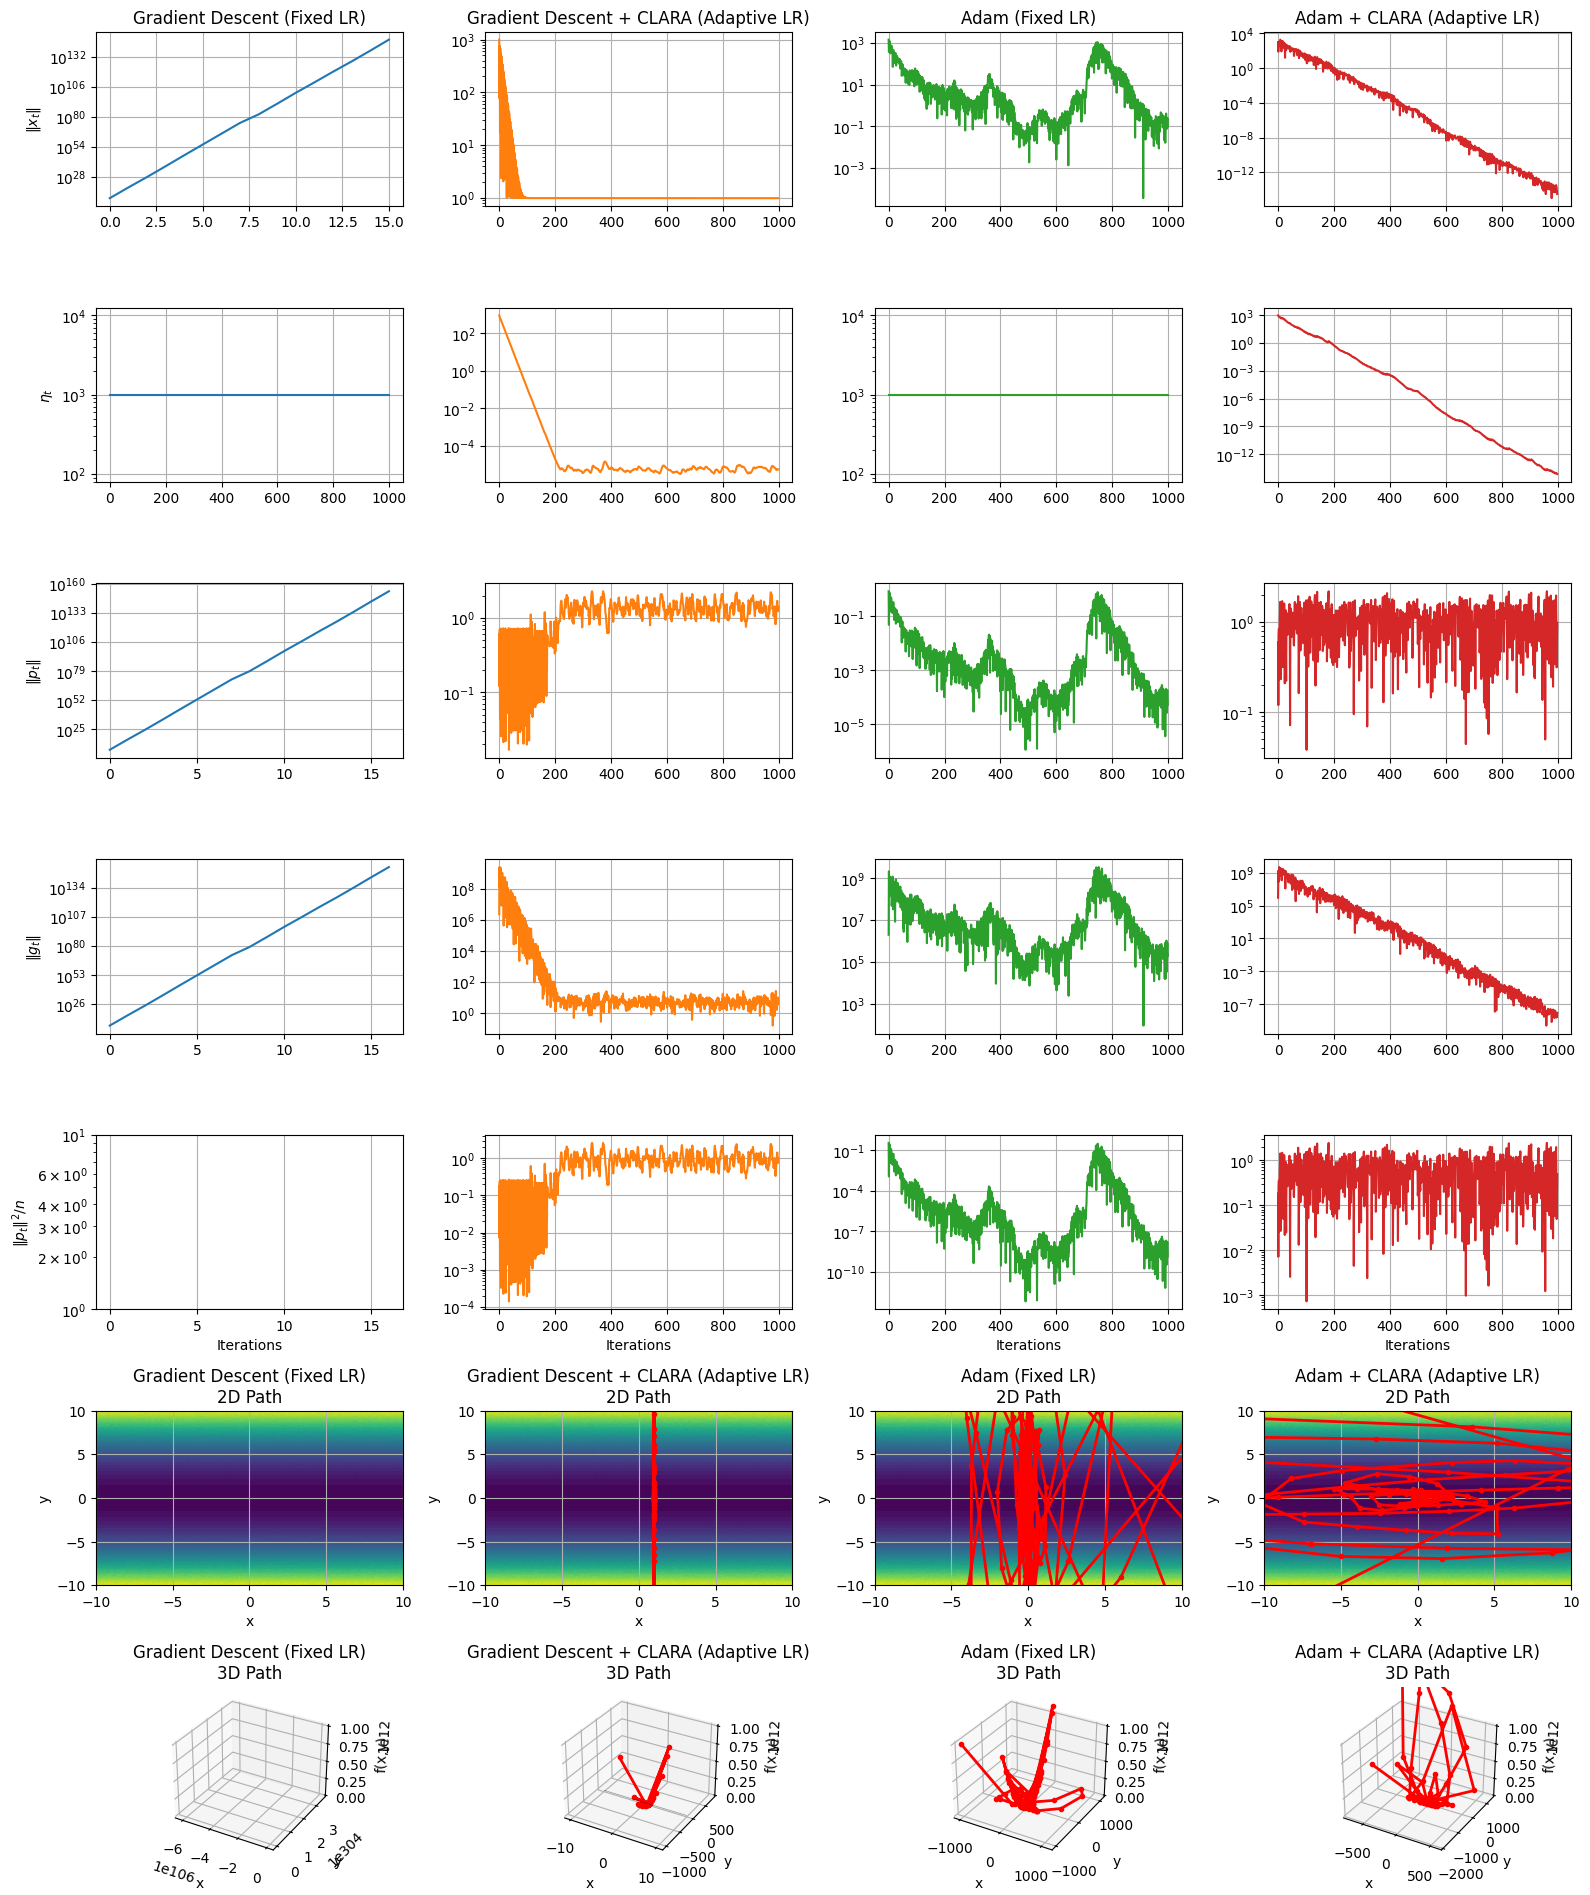

In [18]:
import matplotlib.gridspec as gridspec

# Objective function and path data
objective_function = noisy_ellipsoid
candidate_paths = [candidate_solutions_gd, candidate_solutions_gd_clara, candidate_solutions_adam, candidate_solutions_adam_clara]
method_names = ['Gradient Descent (Fixed LR)', 'Gradient Descent + CLARA (Adaptive LR)',
                'Adam (Fixed LR)', 'Adam + CLARA (Adaptive LR)']
results_all = [results_gd, results_gd_clara, results_adam, results_adam_clara]

# --- Plot Setup ---
row_titles = ['Distance to Optimum', 'Learning Rate', 'Path Norm', 'Gradient Norm', 'Normalized Path Norm']
y_labels = [r'$\|x_t\|$', r'$\eta_t$', r'$\|p_t\|$', r'$\|g_t\|$', r'$\|p_t\|^2 / n$']
n_rows = len(row_titles)
n_cols = len(results_all)
n_extra_rows = 2
total_rows = n_rows + n_extra_rows

fig = plt.figure(figsize=(4 * n_cols, 2.8 * total_rows))
gs = gridspec.GridSpec(total_rows, n_cols)
colormap = plt.colormaps.get_cmap('tab10')
colors = [colormap(i) for i in range(n_cols)]

# --- Metric plots ---
for col, (results, method, color) in enumerate(zip(results_all, method_names, colors)):
    for row in range(n_rows):
        ax = fig.add_subplot(gs[row, col])
        ax.semilogy(results[row], color=color)
        if col == 0:
            ax.set_ylabel(y_labels[row])
        if row == 0:
            ax.set_title(method)
        if row == n_rows - 1:
            ax.set_xlabel('Iterations')
        ax.grid(True)

# --- Path plots below each column ---
xlim = (-10, 10)
ylim = (-10, 10)

for col, (candidate_solutions, method) in enumerate(zip(candidate_paths, method_names)):
    path = np.array(candidate_solutions)

    # Common z range (adapt as needed)
    common_zlim = (1e-2, 1e12)
    
    # Row for 2D Contour
    ax2 = fig.add_subplot(gs[n_rows, col])
    X, Y = np.meshgrid(np.linspace(xlim[0], xlim[1], 200), np.linspace(ylim[0], ylim[1], 200))
    Z = np.array([objective_function(np.array([x, y])) for x, y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)
    ax2.contourf(X, Y, Z, levels=50, cmap='viridis')
    ax2.plot(path[:, 0], path[:, 1], marker='o', color='red', linewidth=2, markersize=3)
    ax2.set_xlim(xlim)
    ax2.set_ylim(ylim)
    ax2.set_title(method + "\n2D Path")
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.grid(True)
    cp = ax2.contourf(X, Y, np.clip(Z, *common_zlim), levels=50, cmap='viridis')


    # Row for 3D Surface
    ax3 = fig.add_subplot(gs[n_rows+1, col], projection='3d')
    ax3.set_zlim(*common_zlim)
    X3, Y3 = np.meshgrid(np.linspace(xlim[0], xlim[1], 100), np.linspace(ylim[0], ylim[1], 100))
    Z3 = np.array([objective_function(np.array([x, y])) for x, y in zip(np.ravel(X3), np.ravel(Y3))]).reshape(X3.shape)
    path_z = [objective_function(p) for p in path]
    ax3.plot_surface(X3, Y3, Z3, cmap='viridis', alpha=0.75)
    ax3.plot(path[:, 0], path[:, 1], path_z, marker='o', color='red', linewidth=2, markersize=3)
    ax3.set_title(method + "\n3D Path")
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')
    ax3.set_zlabel('f(x,y)')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### Testing 3D Plots (interactive)

In [19]:
# Example: Sphere function
def objective_function(x):
    noise = np.random.normal(loc=0, scale=0.01)  # Small Gaussian noise
    return sum(cond**(np.arange(len(x)) / (len(x) - 1 + 1e-9)) * np.asarray(x)**2) * np.exp(noise)

# Optional: Global optimum (0, 0)
global_optimum = np.zeros(2)

# Simulated optimization path (replace with real one)
path = np.array([np.linspace(5, 0, 30), np.linspace(5, 0, 30)]).T
Z_path = [objective_function(p) for p in path]

# Surface grid
x_vals = y_vals = np.linspace(-6, 6, 200)
X, Y = np.meshgrid(x_vals, y_vals)
Z = np.array([objective_function(np.array([x, y])) for x, y in zip(X.ravel(), Y.ravel())]).reshape(X.shape)

# Color gradient for path (red → green)
cmap = plt.colormaps['RdYlGn']
n_points = len(path)
colors = [cmap(i / (n_points - 1)) for i in range(n_points)]
rgb_colors = ['rgb({},{},{})'.format(int(255*r), int(255*g), int(255*b)) for r, g, b, _ in colors]

# Plotly figure
fig = go.Figure()

# 3D surface (loss landscape)
fig.add_trace(go.Surface(
    x=X, y=Y, z=Z,
    colorscale='Viridis',
    opacity=0.9,
    name="Loss Surface",
    colorbar=dict(title='Loss Surface')
))

# Optimization path (colored points + connecting lines)
fig.add_trace(go.Scatter3d(
    x=path[:, 0], y=path[:, 1], z=Z_path,
    mode='lines+markers',
    line=dict(color='darkred', width=3),
    marker=dict(size=4, color=rgb_colors),
    name='Path'
))

# Mark the optimum (e.g. x = [0, 0])
fig.add_trace(go.Scatter3d(
    x=[global_optimum[0]],
    y=[global_optimum[1]],
    z=[objective_function(global_optimum)],
    mode='markers+text',
    marker=dict(size=6, color='purple'),
    text=["Optimum"],
    textposition='top center',
    name="Global Optimum"
))

# Layout & styling
fig.update_layout(
    title="Optimization Path on Objective Surface",
    scene=dict(
        xaxis_title="x",
        yaxis_title="y",
        zaxis_title="f(x, y)",
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.0))
    ),
    width=950,
    height=650,
    margin=dict(l=0, r=0, t=50, b=0),
    font=dict(family="Arial", size=14)
)

fig.show()

In [21]:
for candidate_solutions, method in zip(candidate_paths, method_names):
    path = np.array(candidate_solutions)

    # Generate 3D surface
    X, Y = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
    Z = np.array([objective_function(np.array([x, y])) for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = Z.reshape(X.shape)

    # Path values
    Z_path = [objective_function(p) for p in path]

    # Global minimum (assumed at [0, 0])
    x_min = np.array([0.0, 0.0])
    z_min = objective_function(x_min)

    # Create figure
    fig = go.Figure()

    # Surface
    fig.add_trace(go.Surface(
        z=Z, x=X, y=Y,
        colorscale='Viridis',
        opacity=0.7,
        showscale=False
    ))

    # Path as individual points with a single color
    fig.add_trace(go.Scatter3d(
        x=path[:, 0],
        y=path[:, 1],
        z=Z_path,
        mode='markers+lines',
        marker=dict(
            size=4,
            color='red'  # Single color for markers
        ),
        line=dict(
            width=3,
            color='red'  # Single color for the line
        ),
        name='Optimization Path'
    ))

    # Mark the actual minimum
    fig.add_trace(go.Scatter3d(
        x=[x_min[0]],
        y=[x_min[1]],
        z=[z_min],
        mode='markers+text',
        marker=dict(size=6, color='purple'),
        text=["Global Min"],
        textposition="top center",
        name="Minimum"
    ))

    # Layout
    fig.update_layout(
        title=method + " — 3D Path",
        scene=dict(
            xaxis_title='x',
            yaxis_title='y',
            zaxis_title='f(x, y)'
        ),
        width=800,
        height=600,
        margin=dict(l=0, r=0, t=50, b=0),
        showlegend=False
    )

    fig.show()

/var/folders/yt/dv55bns138ncx2rcqf776gwm0000gn/T/ipykernel_47435/4208840194.py:4: RuntimeWarning:

overflow encountered in square



##### We tested...
- **GD with extremely small LR** (`1e-10`)
- **Adam with very large LR** (`1e6`)
- **Adam + CLARA** with the same large LR (`1e6`)
This was to compare **stability and adaptability** of the optimizers under mismatched or extreme learning rates.

----
### ✅ Summary of Findings

| Optimizer          | Behavior                | Verdict                     |
|--------------------|--------------------------|-----------------------------|
| GD, small LR       | Very slow, but stable    | Ineffective under noise     |
| Adam, large LR     | Unstable, noisy updates  | No built-in protection      |
| Adam + CLARA, large LR | Stable, adaptive, convergent | ✅ Success case for paper |

These plots demonstrate that:
> CLARA enables stable and effective optimization under extreme learning rate settings, while fixed learning rate methods either fail to converge (Adam) or converge extremely slowly (GD).

🔜 Next steps
- Run on more realistic RL settings (e.g. tabular environments or simple Gym tasks)
- Compare to D-Adaptation and other advanced LR methods
- Theoretical analysis of stability and convergence (optional)
- Test across different condition numbers / dimensions to explore robustness

---